# Lab 1, EV Charging Stations Data analysis

Student Name: Sandro Juric & Scotty Seethoff

### AI usage disclaimer
I have used the Copilot in this project, primarily for code refactoring in VS Code

# Business Understanding

Driving pure electric vehicles comes with new challenges that new and existing consumers face. Of those range anxiety is the most significant hurdle that EV driver faces in most countries. A common issue with most electric vehicles is that they typically need to be recharged after around two hundred miles of driving. While many EV drivers have home charging stations, the problem apperent during road trips. 

Therefore, having charging stations available becomes paramount to a successful road trip experience in an EV car. There are four main factors to consider when dealing with EV charging stations. Firstly, are there any charging stations available in the area where you will be driving? Secondly, do those available stations support fast DC charging and which rate can you expect the output to be? Next, do the available charging station support the type of charging connector you can have? Finally, are the stations available in good working conditions, or mostly offline?

The dataset analysed is for the global EV charging stations and will describe the state of each country EV infrastructure. Real-time data from 123 active countries, spanning 2010 to 2026, has been gathered to illustrate the growth of electric vehicles and assess the reliability of individual stations. Along with geographic data, the data includes station status, maximum power output, available connectors, and which year it was created.

My hypothesis is that the global EV infrastructure has grown significantly over the years and that will continue to grow in the decades to come. With the analysis we will explore if that is the case and what countries have reached a critical density of reliable EV station for an everyday consumer to feel comfortable driving anywhere in their EV without extensive planning.

Dataset: https://www.kaggle.com/datasets/sohails07/global-ev-charging-station-network-2010-2026


# Data Understanding

In [1]:
import pandas as pd
import numpy as np

# Suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'
# Ensure future behavior for downcasting is explicit
pd.set_option('future.no_silent_downcasting', True)

df = pd.read_csv('global_ev_charging_station.csv')

# select relevant columns
dfSelect = df[['StationID', 'Country', 'Town', 'Latitude', 'Longitude', 'MaxPowerKW', 'ConnectionTypes', 'StatusType', 'YearCreated']]

# remap connection types to broader categories
connection_type_map = {
    'CHAdeMO': 'Fast',
    'CCS (Type 1)': 'Fast',
    'CCS (Type 2)': 'Fast',
    'Tesla Supercharger': 'Fast',
    'Type 2': 'Standard',
    'Type 1': 'Standard',
    'J1772': 'Standard',
    'GB/T': 'Fast',
    'Schuko': 'Slow',
    'Ceeform (Blue)': 'Slow',
    'Ceeform (Red)': 'Slow'
}


dfSelect['ConnectionTypes'] = dfSelect['ConnectionTypes'].map(connection_type_map).fillna('Other')

# remap status types to simplified categories
status_type_map = { 
    'Operational': True,
    'Under Construction': False,
    'Planned': False,
    'Temporarily Unavailable': False,
    'Removed': False
}

# convert StatusType to boolean
dfSelect['StatusType'] = dfSelect['StatusType'].map(status_type_map).astype('bool', errors='ignore')

# handle missing values for Town and Country

# Impute the town using the country
dfSelect['Town'] = dfSelect.groupby('Country')['Town'].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x)
)

# Impute Town based on most common Town within each Country
dfSelect['Town'] = dfSelect.groupby('Country')['Town'].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'Unknown')
)

# Impute City based on most common City within each Country
dfSelect['Town'] = dfSelect.groupby('Country')['Town'].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'Unknown')
)

#if that doesn't work, just fallback to 'Unknown'
dfSelect['Town'] = dfSelect['Town'].fillna('Unknown')
dfSelect['Country'] = dfSelect['Country'].fillna('Unknown')

# rename columns for clarity
dfSelect.rename(columns={
    'Town': 'City', 
    'MaxPowerKW': 'Rate', 
    'YearCreated': 'Built', 
    'ConnectionTypes': 'Charge Rate', 
    'StatusType': 'Is Online', 
    'Latitude': 'Lat', 
    'Longitude': 'Long', 
    'StationID':'Station ID'}, inplace=True)

# format and display of the first few rows
# used the pandas Styler for better visualization in Jupyter Notebooks https://pandas.pydata.org/docs/user_guide/style.html
display(dfSelect.head(10).style.background_gradient(axis=None, cmap="YlGnBu"))

,Station ID,Country,City,Lat,Long,Rate,Charge Rate,Is Online,Built
0,473101,United Kingdom,London,51.371709,-0.116955,250.000000,Fast,True,2026
1,472908,United Kingdom,Wythenshawe,53.366453,-2.269799,11.000000,Other,True,2026
2,472220,United Kingdom,Belfast,54.586836,-5.926869,50.000000,Fast,True,2025
3,471954,United Kingdom,Dungannon,54.509453,-6.768057,22.000000,Other,True,2025
4,471953,United Kingdom,Armagh,54.350644,-6.641787,22.000000,Other,True,2025
5,471952,United Kingdom,Armagh,54.349971,-6.642684,22.000000,Other,True,2025
6,471951,United Kingdom,Craigavon,54.435689,-6.411357,22.000000,Other,True,2025
7,471950,United Kingdom,Portadown,54.433089,-6.410223,22.000000,Other,True,2025
8,471949,United Kingdom,Lurgan,54.456608,-6.338349,22.000000,Other,True,2025
9,471948,United Kingdom,Rathfriland,54.236068,-6.162224,22.000000,Other,True,2025


### Data Cleanup
Picked the relavent features for analysis and discarded rest. Mapped over Charge Rate based on common known mapping and set unknown data to "Other". Mapped over the operational status to boolean, it's either online or not.  Renamed columns for easer read and formated the output.

In [2]:
dfSelect.info()


print("\n")
print("Data Summary Statistics:")

# Display summary statistics
display(dfSelect.describe(include='all'))

# Display number of records with unknown values with percentages
unknown_cities_count = dfSelect[dfSelect['City'] == 'Unknown'].shape[0]
print(f"Number of records with unknown cities: {unknown_cities_count} ({unknown_cities_count / len(dfSelect) * 100:.2f}%)")

unknown_countries_count = dfSelect[dfSelect['Country'] == 'Unknown'].shape[0]
print(f"Number of records with unknown countries: {unknown_countries_count} ({unknown_countries_count / len(dfSelect) * 100:.2f}%)")

unknown_connection_types_count = dfSelect[dfSelect['Charge Rate'] == 'Unknown'].shape[0]
print(f"Number of records with 'Unknown' connection types: {unknown_connection_types_count} ({unknown_connection_types_count / len(dfSelect) * 100:.2f}%)")

offline_stations_count = dfSelect[dfSelect['Is Online'] == False].shape[0]
print(f"Number of offline stations: {offline_stations_count} ({offline_stations_count / len(dfSelect) * 100:.2f}%)")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257585 entries, 0 to 257584
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Station ID   257585 non-null  int64  
 1   Country      257585 non-null  object 
 2   City         257585 non-null  object 
 3   Lat          257585 non-null  float64
 4   Long         257585 non-null  float64
 5   Rate         257585 non-null  float64
 6   Charge Rate  257585 non-null  object 
 7   Is Online    257585 non-null  bool   
 8   Built        257585 non-null  int64  
dtypes: bool(1), float64(3), int64(2), object(3)
memory usage: 16.0+ MB


Data Summary Statistics:


,Station ID,Country,City,Lat,Long,Rate,Charge Rate,Is Online,Built
count,257585.000000,257585,257585,257585.000000,257585.000000,257585.000000,257585,257585,257585.000000
unique,NaN,123,43777,NaN,NaN,NaN,2,2,NaN
top,NaN,United States,Paris,NaN,NaN,NaN,Other,True,NaN
freq,NaN,86904,10823,NaN,NaN,NaN,240001,252412,NaN
mean,214027.344244,NaN,NaN,43.024583,-32.331054,36.094556,NaN,NaN,2021.177984
std,112354.931522,NaN,NaN,13.060504,57.567388,1971.171374,NaN,NaN,3.404048
min,2389.000000,NaN,NaN,-55.811599,-164.848855,0.000000,NaN,NaN,2010.000000
25%,127474.000000,NaN,NaN,38.785981,-81.528641,3.700000,NaN,NaN,2019.000000
50%,213775.000000,NaN,NaN,44.293968,-3.117260,11.000000,NaN,NaN,2023.000000
75%,289084.000000,NaN,NaN,51.343085,7.690003,22.000000,NaN,NaN,2024.000000


Number of records with unknown cities: 2 (0.00%)
Number of records with unknown countries: 0 (0.00%)
Number of records with 'Unknown' connection types: 0 (0.00%)
Number of offline stations: 5173 (2.01%)


## Data Analysis

Unknown city in data is below 10% and we still have long & lat data for those records so these can be safely ignored as mapping it can still be done to a map.

There are no unknown countries and the number of offline station is statistically insignificant to matter for the final analysis so we can ignore those.

However connection types are a big issue as the majority of the records didn't fall with the mapping range, we'll need to adjust that before proceding.

In [ ]:
#Cleaning
df.columns = df.columns.str.strip()

dfSelect = df[
    ["StationID", "Country", "Town", "Latitude", "Longitude", "MaxPowerKW", "StatusType", "YearCreated", "ConnectionTypes"]
].copy()

# had to rename it again to what we named it in the previous cell to make it work
dfSelect.rename(columns={
    "StationID": "Station ID",
    "Town": "City",
    "Latitude": "Lat",
    "Longitude": "Long",
    "MaxPowerKW": "Rate",
    "StatusType": "Is Online",
    "YearCreated": "Built",
    "ConnectionTypes": "ConnectionTypes"  
}, inplace=True)

# raw connector column
RAW_CONNECTION_COL = "ConnectionTypes"
DERIVED_COL = "Charge Rate"   

# Inspect raw values 
unique_connection_types = (
    dfSelect[RAW_CONNECTION_COL]
    .dropna()
    .astype(str)
    .unique()
)

print("Total number of unique raw connection strings:", len(unique_connection_types))
print("Sample raw connection strings:")
print(unique_connection_types[:10])

# Categorizing function
def categorize_connection_type(connection_types):
    if pd.isna(connection_types):
        return "Unknown"

    # Use substring matching to catch variants
    fast_types = [
        "CCS", "CHADEMO", "SUPERCHARGER", "NACS",
        "GB-T DC", "GB/T 20234.3", "CHAOJI"
    ]
    standard_types = [
        "TYPE 1", "TYPE 2", "J1772", "TESLA",
        "GB-T AC", "GB/T 20234.2", "TYPE I", "TYPE II"
    ]
    slow_types = [
        "SCHUKO", "CEE", "BS1363", "EUROPLUG",
        "NEMA", "IEC 60309", "SCAME", "3 PIN", "WIRELESS"
    ]

    raw = str(connection_types).upper().replace(";", ",")
    connectors = [c.split("(")[0].strip() for c in raw.split(",") if c.strip()]

    # Fast Standard Slow
    if any(any(f in c for f in fast_types) for c in connectors):
        return "Fast"
    if any(any(s in c for s in standard_types) for c in connectors):
        return "Standard"
    if any(any(s in c for s in slow_types) for c in connectors):
        return "Slow"
    return "Unknown"

dfSelect[DERIVED_COL] = dfSelect[RAW_CONNECTION_COL].apply(categorize_connection_type)

# Validation
dist = dfSelect[DERIVED_COL].value_counts(normalize=True).mul(100).round(2)
print("\nCharge Rate distribution (%):")
print(dist)

unknown_samples = (
    dfSelect.loc[dfSelect[DERIVED_COL] == "Unknown", RAW_CONNECTION_COL]
    .dropna()
    .astype(str)
    .unique()[:10]
)

print("\nSample Unknown raw strings after mapping:")
print(unknown_samples)

Total number of unique raw connection strings: 474
Sample raw connection strings:
['CCS (Type 2)' 'Type 2 (Socket Only)'
 'CCS (Type 2), Type 2 (Socket Only)' 'Type 2 (Tethered Connector)'
 'CCS (Type 2), CHAdeMO' 'CCS (Type 1)'
 'CCS (Type 2), CHAdeMO, Type 2 (Tethered Connector)' 'CHAdeMO'
 'CCS (Type 2), CHAdeMO, Type 2 (Socket Only)' 'BS1363 3 Pin 13 Amp']

Charge Rate distribution (%):
Charge Rate
Standard    71.10
Fast        24.66
Slow         2.24
Unknown      2.00
Name: proportion, dtype: float64

Sample Unknown raw strings after mapping:
['Blue Commando (2P+E)' 'SP Inductive' 'Avcon Connector' 'LP Inductive'
 'Three Phase 5-Pin (AS/NZ 3123)' 'Type M'
 'T13 - SEC1011 ( Swiss domestic 3-pin ) - Type J']


# Data Visualization

# Dimensionality Reduction Method

Present the results as using charts (see [Python Code Examples/charts and tables](../HOWTOs/charts_and_tables.ipynb)).

=== Rate Data Quality ===
Non-null numeric values: 257585 / 257585 (100.00%)


count     257585.000000
mean          36.094556
std         1971.171374
min            0.000000
25%            3.700000
50%           11.000000
75%           22.000000
max      1000000.000000
Name: Rate, dtype: float64

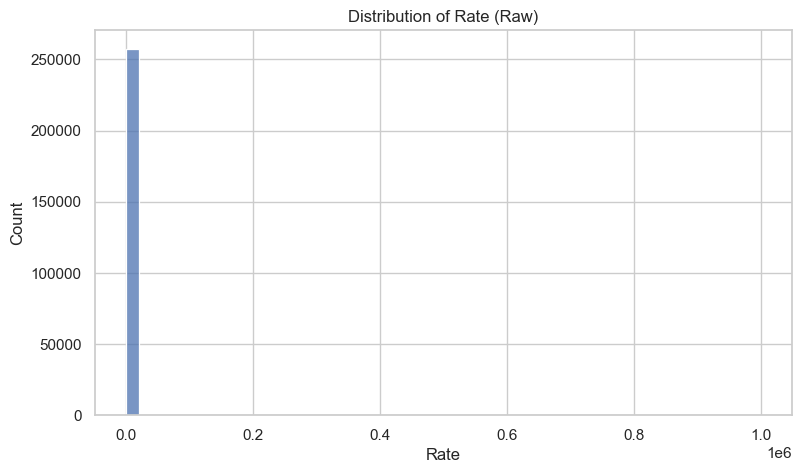

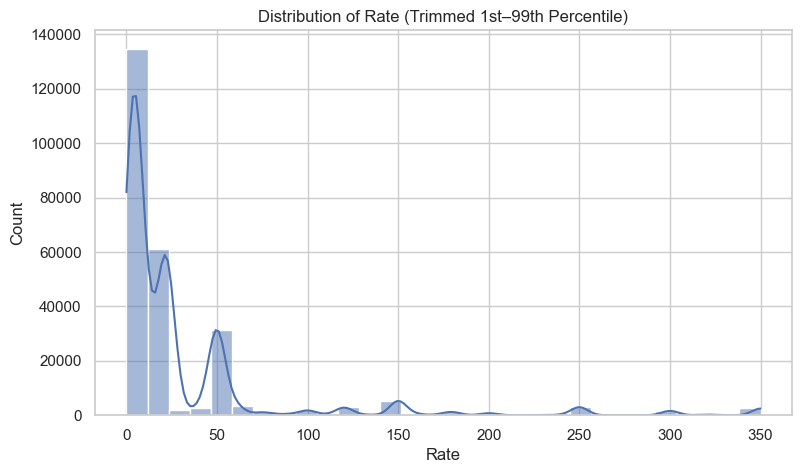

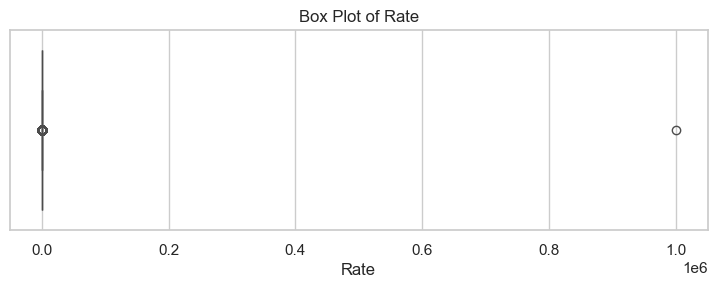

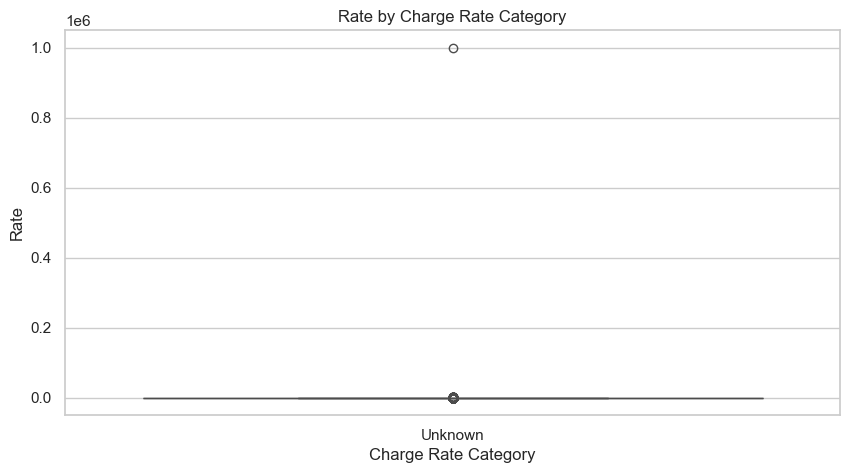


=== Charge Rate counts used in plot ===


Charge Rate
Unknown    257585
Name: count, dtype: int64


=== Power/Rate column candidates in dfSelect ===
['Rate', 'Charge Rate']


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

POWER_COL = "Rate"

if POWER_COL not in dfSelect.columns:
    raise KeyError(f"Column '{POWER_COL}' not found. Available columns include: {dfSelect.columns.tolist()[:30]}")

dfPlot = dfSelect.copy()

# Convert to num
dfPlot[POWER_COL] = pd.to_numeric(dfPlot[POWER_COL], errors="coerce")

rate = dfPlot[POWER_COL].dropna()

print(f"=== {POWER_COL} Data Quality ===")
print(f"Non-null numeric values: {len(rate)} / {len(dfPlot)} ({len(rate)/len(dfPlot)*100:.2f}%)")
display(rate.describe())

#error message if it doesn't convert to numeric or if all values are non-numeric
if len(rate) == 0:
    raise ValueError(
        f"No numeric values found in '{POWER_COL}'. "
        f"Try a different column (e.g., Power_kW) or inspect raw values:\n"
        f"{dfSelect[POWER_COL].astype('string').dropna().head(10).tolist()}"
    )

# histogram
plt.figure(figsize=(9,5))
sns.histplot(rate, bins=50, kde=False)
plt.title(f"Distribution of {POWER_COL} (Raw)")
plt.xlabel(POWER_COL)
plt.ylabel("Count")
plt.show()

#Trimmed version of the histogram
low, high = rate.quantile([0.01, 0.99])
rate_trim = rate[(rate >= low) & (rate <= high)]

plt.figure(figsize=(9,5))
sns.histplot(rate_trim, bins=30, kde=True)
plt.title(f"Distribution of {POWER_COL} (Trimmed 1st–99th Percentile)")
plt.xlabel(POWER_COL)
plt.ylabel("Count")
plt.show()

#Box plot
plt.figure(figsize=(9,2.6))
sns.boxplot(x=rate)
plt.title(f"Box Plot of {POWER_COL}")
plt.xlabel(POWER_COL)
plt.show()

# compare by group
if "Charge Rate" in dfPlot.columns:
    # Dropping the rows where Charge Rate is missing
    df_group = dfPlot.dropna(subset=["Charge Rate", POWER_COL])
    # If too many unique categories only keep the main ones

    plt.figure(figsize=(10,5))
    sns.boxplot(data=df_group, x="Charge Rate", y=POWER_COL)
    plt.title(f"{POWER_COL} by Charge Rate Category")
    plt.xlabel("Charge Rate Category")
    plt.ylabel(POWER_COL)
    plt.show()

    print("\n=== Charge Rate counts used in plot ===")
    display(df_group["Charge Rate"].value_counts())

# show the column candidates if you need to pick a better power column
print("\n=== Power/Rate column candidates in dfSelect ===")
print([c for c in dfSelect.columns if ("rate" in c.lower()) or ("kw" in c.lower()) or ("power" in c.lower())])

## UMAP

In [ ]:
import numpy as np
import pandas as pd
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns


#cleaning and preprocessing for UMAP
dfSelect.columns = dfSelect.columns.str.strip()
for c in ["Country", "City", "Charge Rate"]:
    if c in dfSelect.columns:
        dfSelect[c] = dfSelect[c].astype("string").str.strip()

drop_cols = [c for c in ["Station ID", "ID"] if c in dfSelect.columns]

# Keep top-K most frequent categoriesthen map the rest to "Other"
# reduces memory usage
def reduce_cardinality(series: pd.Series, top_k: int = 30, other_label: str = "Other") -> pd.Series:
    s = series.astype("string").fillna(other_label).str.strip()
    top = s.value_counts().head(top_k).index
    return s.where(s.isin(top), other_label)

# Choose categories to reduce
TOP_K_COUNTRY = 30
TOP_K_CITY = 50

if "Country" in dfSelect.columns:
    dfSelect["Country_reduced"] = reduce_cardinality(dfSelect["Country"], top_k=TOP_K_COUNTRY)
else:
    dfSelect["Country_reduced"] = "Other"

if "City" in dfSelect.columns:
    dfSelect["City_reduced"] = reduce_cardinality(dfSelect["City"], top_k=TOP_K_CITY)
else:
    dfSelect["City_reduced"] = "Other"

if "Charge Rate" in dfSelect.columns:
    dfSelect["Charge Rate"] = dfSelect["Charge Rate"].astype("category")

if "Is Fast Charge" not in dfSelect.columns and "Charge Rate" in dfSelect.columns:
    dfSelect["Is Fast Charge"] = (dfSelect["Charge Rate"].astype("string").str.upper() == "FAST").astype(int)

X = dfSelect.drop(columns=drop_cols, errors="ignore").copy()

categorical_cols = [c for c in ["Country_reduced", "City_reduced", "Charge Rate"] if c in X.columns]

numeric_cols = X.select_dtypes(include=["number", "bool"]).columns.tolist()

high_card_text = [c for c in ["ConnectionTypes", "Address", "Station Name", "Name", "Operator", "Description"] if c in X.columns]
X = X.drop(columns=high_card_text, errors="ignore")

categorical_cols = [c for c in categorical_cols if c in X.columns]
numeric_cols = X.select_dtypes(include=["number", "bool"]).columns.tolist()

print("Numeric columns used:", numeric_cols)
print("Categorical columns used:", categorical_cols)
print("Rows:", len(X))

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), categorical_cols),
    ],
    remainder="drop"
)

X_processed = preprocessor.fit_transform(X)
print("Processed shape:", X_processed.shape)

# UMAP embedding
umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric="euclidean",
    random_state=42
)

X_umap = umap_model.fit_transform(X_processed)

df_umap = dfSelect.copy()
df_umap["UMAP_1"] = X_umap[:, 0]
df_umap["UMAP_2"] = X_umap[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_umap,
    x="UMAP_1",
    y="UMAP_2",
    hue="Charge Rate" if "Charge Rate" in df_umap.columns else None,
    alpha=0.5,
    s=12
)
plt.title("UMAP Projection of EV Charging Stations (Reduced Cardinality Categoricals)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Charge Rate", loc="best")
plt.show()

KeyboardInterrupt: 